# Part 3. Model Building
- Fit a model that predicts the outcome variable using two or more independent variables
- Check model assumptions
- Evaluate the model

In [1]:
# Import libraries and shared functions
from helpers import *

In [2]:
# Create a dataframe to store results
res = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

In [3]:
# Import cleaned dataset
df = pd.read_csv("hr_data.csv")

#### Transform data for models that require encoding of categorical features and are sensitive to outliers 

In [4]:
# Copy the dataframe
df_encoded = df.copy()

# Encode the 'salary' column as an ordinal numeric category since there is a difference in levels
df_encoded['salary'] = (df_encoded['salary'].astype('category')
                         .cat.set_categories(['low', 'medium', 'high'])
                         .cat.codes)

# Perform one-hot encoding of the 'department' column
df_encoded = pd.get_dummies(data=df_encoded, columns=['department'], drop_first=False)

# Display the new dataframe
df_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [36]:
# Save encoded data frame
df_encoded.to_csv('hr_data_encoded.csv', index=False)

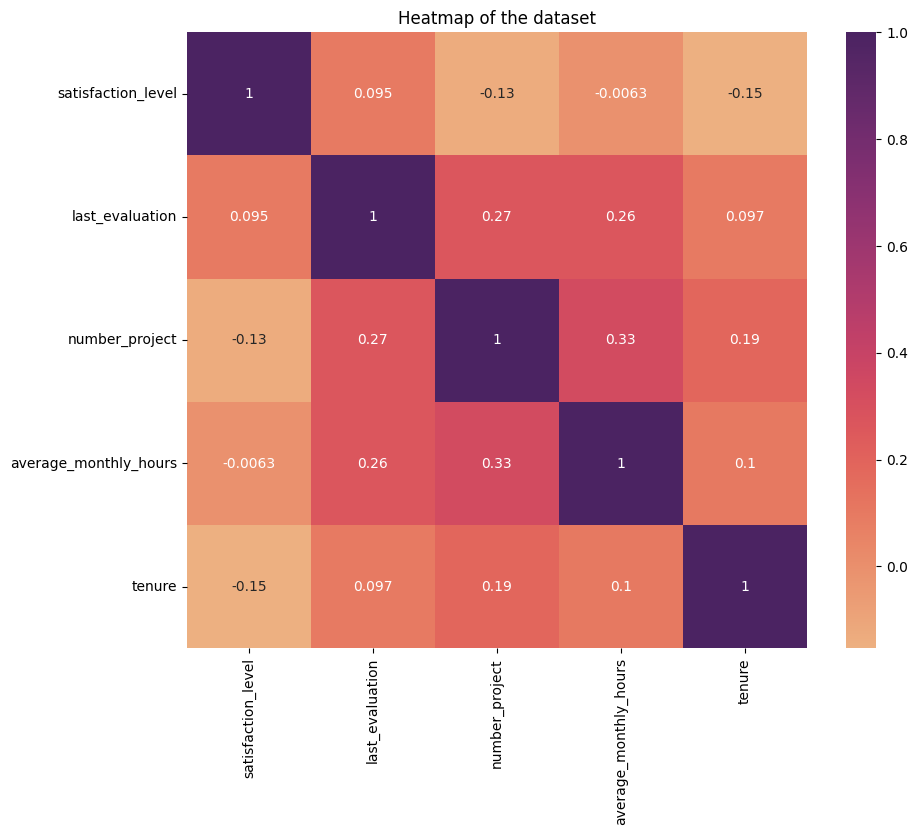

In [6]:
# Create a heatmap to explore correlations between variables, checking multicollinearity
plt.figure(figsize=(10, 8))

# Get continuous or discrete variables list
numeric_features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']

# Build the plot
sns.heatmap(df_encoded[numeric_features].corr(), annot=True, cmap='flare')
plt.title('Heatmap of the dataset')
plt.show()

In [7]:
# Check variance inflation factors for multicollinearity assumption

# Add a constant for intercept to use in statsmodels
const_X = sm.add_constant(df_encoded[numeric_features])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = const_X.columns

# VIF calculation for each variable
vif_data['VIF'] = [variance_inflation_factor(const_X.values, i) for i in range(const_X.shape[1])]
vif_data

,feature,VIF
0,const,41.608335
1,satisfaction_level,1.058663
2,last_evaluation,1.144426
3,number_project,1.223627
4,average_monthly_hours,1.168686
5,tenure,1.061488


Variance inflation factor matrics for variables that were not encoded using one-hot encoding are not higher than 1.23, suggesting very low correlation between variables. 

Since logistic regression is quite sensitive to outliers, will remove the outliers in the tenure column that were identified earlier.

In [8]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable

# Get interquartile range for 'tenure' column
q1 = df['tenure'].quantile(0.25)
q3 = df['tenure'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr

df_filter_outliers = df_encoded[(df_encoded['tenure'] >= lower_limit) & (df_encoded['tenure'] <= upper_limit)]

df_filter_outliers.head(10)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
5,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
6,0.10,0.77,6,247,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0
7,0.92,0.85,5,259,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
8,0.89,1.00,5,224,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,0.42,0.53,2,142,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
10,0.45,0.54,2,135,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [9]:
# Perform train test split 

# Isolate target variable
y_filt = df_filter_outliers['left']

# Select features
X_filt = df_filter_outliers.drop('left', axis=1)

# Split the data into training set and testing set, setting y stratification due to unbalanced classes
X_filt_train, X_filt_test, y_filt_train, y_filt_test = train_test_split(X_filt, y_filt, test_size=0.25, stratify=y_filt, random_state=5)


### Modeling Approach A: Logistic Regression Model

In [10]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=5, max_iter=400).fit(X_filt_train, y_filt_train)

In [12]:
# Use the logistic regression model to get predictions on the test set
y_pred_lg = log_clf.predict(X_filt_test)

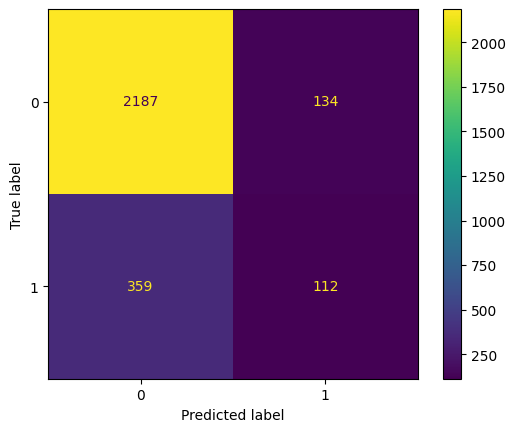

In [13]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_filt_test, y_pred_lg, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix suppressing scientific notation 
log_disp.plot(values_format='')

# Display plot
plt.show()

Current logistic regression model predicted:

* 2187 true negatives (upper-left quadrant): people who did not leave and were correctly predicted as not leaving.
* 134 false positives (upper-right quadrant): people who did not leave but were incorrectly predicted as leaving.
* 359 false negatives (bottom-left quadrant): people who left but were incorrectly predicted as not leaving.
* 112 true positives (bottom-right quadrant): people who left and were correctly predicted as leaving.

A perfect model would predict all true negatives and true positives, and no false negatives or false positives.

In [14]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_filt_test, y_pred_lg, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.94      0.90      2321
    Predicted would leave       0.46      0.24      0.31       471

                 accuracy                           0.82      2792
                macro avg       0.66      0.59      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80% (all in weighted averages), and accuracy of 82%. 

However, the main goal is to predict employees who leave and the scores for correct predictions of employees who left are very low.

In [15]:
# Collect results for logistic regression model
res = make_results('Logistic Regression', log_clf, X_filt_test, y_filt_test, res)
res

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.823424,0.455285,0.237792,0.312413,0.885256


Recall and f1 scores of the model are very low.

### Modeling Approach B: Naive Bayes Model
Implementation of Gaussian Naive Bayes. Not all the features are normally distributed. 

In [16]:
# Instantiate and fit the model
nb = GaussianNB()

nb.fit(X_filt_train, y_filt_train)

# Predict on test data. 
y_pred_nb = nb.predict(X_filt_test)

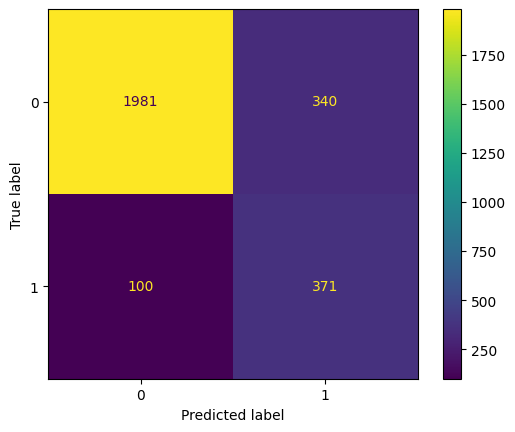

In [18]:
# Construct the confusion matrix for your predicted and test values.
cm = confusion_matrix(y_filt_test, y_pred_nb)

# Create the display for your confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=nb.classes_)

# Plot the visual in-line.
disp.plot()

Current naive bayes model predicted:

* 1981 true negatives (upper-left quadrant): people who did not leave and were correctly predicted as not leaving.
* 340 false positives (upper-right quadrant): people who did not leave but were incorrectly predicted as leaving.
* 100 false negatives (bottom-left quadrant): people who left but were incorrectly predicted as not leaving.
* 371 true positives (bottom-right quadrant): people who left and were correctly predicted as leaving.


In [20]:
# Make a classification report
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_filt_test, y_pred_nb, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.95      0.85      0.90      2321
    Predicted would leave       0.52      0.79      0.63       471

                 accuracy                           0.84      2792
                macro avg       0.74      0.82      0.76      2792
             weighted avg       0.88      0.84      0.85      2792



The classification report above shows that the Gaussian Naive Bayes model achieved a precision of 88%, recall of 84%, f1-score of 85% (all in weighted averages), and accuracy of 84%. These results are better than results of logistic regression model. 

In [21]:
# Collect results for Naive Bayes model
res = make_results('Naive Bayes', nb, X_filt_test, y_filt_test, res)
res

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.823424,0.455285,0.237792,0.312413,0.885256
1,Naive Bayes,0.842407,0.521800,0.787686,0.627750,0.859302


Prediction metrics of recall and F1 scores of employees who left are significantly better than logistic regression model. 

#### Construct models that do not equire encoding of categorical features

In [22]:
# Isolate the outcome variable without encoding 
y = df_encoded['left']

# Select the features
X = df_encoded.drop('left', axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=5)

### Modeling Approach C: Decision Tree Model
Implementation of Decision Tree Classifier with a cross-validated grid-search to exhuastively search for the best model parameters 

In [24]:
# Instantiate model
tree1 = DecisionTreeClassifier(random_state=5)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}
# Instantiate GridSearch
tree1 = GridSearchCV(tree1, cv_params, scoring=scoring, cv=5, refit='recall')

In [25]:
%%time
tree1.fit(X_train, y_train)

CPU times: user 4.62 s, sys: 115 ms, total: 4.74 s
Wall time: 4.79 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [26]:
# Check best parameters
tree1.best_params_

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [27]:
# Check best recall score on CV
tree1.best_score_

0.9216201656528472

This is a strong recall score, which shows that this model can predict employees who will leave very well.

In [28]:
# Extract results of cross validaded Decision Tree Classifier
res = make_results('Decision Tree CV', tree1, X_test, y_test, res)
res

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.823424,0.455285,0.237792,0.312413,0.885256
1,Naive Bayes,0.842407,0.521800,0.787686,0.627750,0.859302
2,Decision Tree CV,0.978986,0.955975,0.915663,0.935385,0.964097


All results from the decision tree model are indicating a good model performance.

However, decision trees can be vulnerable to overfitting.

### Modeling Approach D: Random Forest Model
Construct a random forest model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [30]:
# Instantiate model
rf = RandomForestClassifier(random_state=5)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1, 3],
             'min_samples_split': [2, 4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [31]:
%%time
rf_cv.fit(X_train, y_train) # ~8 min

CPU times: user 11min 30s, sys: 7.29 s, total: 11min 37s
Wall time: 11min 57s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 4],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [32]:
# Write pickle
write_pickle(rf_cv, 'hr_rf1')

# Read pickle
# rf1 = read_pickle('hr_rf1')

In [33]:
# Check best recall score on CV
rf_cv.best_score_

0.9216224102713744

In [34]:
# Check best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [35]:
# Get random forest CV scores
res = make_results('Random Forest CV', rf_cv, X_test, y_test, res)
res

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.823424,0.455285,0.237792,0.312413,0.885256
1,Naive Bayes,0.842407,0.521800,0.787686,0.627750,0.859302
2,Decision Tree CV,0.978986,0.955975,0.915663,0.935385,0.964097
3,Random Forest CV,0.982322,0.974414,0.917671,0.945191,0.973490


The evaluation scores of the random forest model are better than those of the decision tree model. This indicates that the random forest model mostly outperforms the decision tree model.